# A quick implementation
After understanding our data in the previous section, [descriptive statistics](./descriptive_statistics.ipynb), we now want to quickly run a time-series forecast using [gluonts](https://github.com/awslabs/gluon-ts).
In this example we use the same dataset as before and apply two separate models, [DeepAR](https://arxiv.org/abs/1704.04110) and a simple multi-layer perceptron. At the end we shall compare the results of the evaluation of both models.

In [56]:
import pandas as pd
import gluonts
import numpy as np
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.util import to_pandas
import pathlib
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator

## Settingup hyperparameters
Here we just set the number of epochs and rely on default values for the rest of the parameters in order to make the example more understandable.

In [2]:
EPOCHS = 20

## Loading the data

In [3]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"

In [4]:
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)
df.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


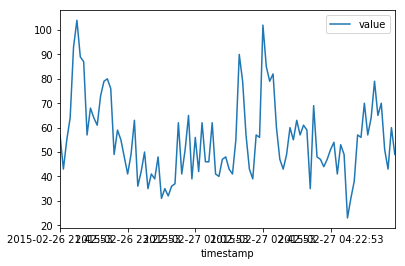

In [5]:
df[:100].plot()

## Plotting forecast helper function
The below function plots a forecast for a given data and a given predictor. Let's dive deeper into components of this funciton.
`from gluonts.model` includes a number of implemented models models. Each model has an estimator. An estimator accepts a series of model and hyperparameters. parameters include a trainer that accepts optimization parameters. The estimator also accepts parameters such as context, number of layers, context length, time-series frequency, and prediction length amongst others.
The estimator has a `train` method that is used for fitting the data. The `train` method retuns a predictor that can be used to forecast based on input data.

`plot_forecast` function accepts a `predictor` object and an iterable dataset to plot the data and the forecast.

The centerpiece of the forecast function is `forecast.plot`. It plots the forecast in different confidence intervals

In [42]:
def plot_forecast(predictor, test_data):
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        to_pandas(test_entry)[-60:].plot(linewidth=2)
        forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
    plt.grid(which='both')

## Dataset
`gluonts.dataset.common` has a class `ListDataset`. GluonTS does not require this specific format for a custom dataset that a user may have. The only requirements for a custom dataset are to be iterable and have a "target" and a "start" field. To make this more clear, assume the common case where a dataset is in the form of a `numpy.array` and the index of the time series in a `pandas.Timestamp`.

In this example we are using a `gluonts.dataset.common.ListDataset`. We pass a *start* as `pandas.index` and a *target* as an iterable set of timestamp values from the our pandas dataframe.

In the followng cell we build a training dataset ending at April 5th, 2015 and a test dataset that will be used forecast the hour following the midnight on April 15th, 2015.

In [43]:
training_data = ListDataset([{"start": df.index[0], 
                              "target": df.value[: "2015-04-05 00:00:00"]}], 
                            freq="5min")

test_data = ListDataset([{"start": df.index[0], 
                           "target": df.value[:"2015-04-15 00:00:00"]}], 
                        freq="5min")

## Create an estimator
An estimator object represents the network, contains a trainer, which in turn includes batch size, initializer, context, learning rate and other training specific hyperparameters. The estimator object also includes frequency of timestamp, prediction length to express how many steps we want to predict, and structural parameters such as number of layers. The estimator also crucially includes a `train` method. The train method is used to fit a model to a given dataset and trurns a predictor object, which can be uesed to predict/forecast values.

In the following examples we create a DeepAR estimator. For more informatino on DeepAR, please refer to the [paper](https://arxiv.org/abs/1704.04110) based on wich the model is being developed.

The frequnecy parameter needs to be the same as accepted frequencies by pandas. For more information on pandas use of frequency please refer to the [documentation of pandas date_range.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html)
Finally the `prediction_length` is set to 12. We aim to predict tweets for the next hour and as the data has `freq=5min`, we opt 12 steps, which is 12x5min = 60min or one hour.

In [57]:
deepar_estimator = DeepAREstimator(freq="5min", prediction_length=12, trainer=Trainer(epochs=EPOCHS))

## Fitting the model.
We simply call `train` method of the `deepar_estimator` we just created and pass our iterable training data to the train method. The output is a predictor object.  

In [58]:
deepar_predictor = deepar_estimator.train(training_data=training_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.90it/s, avg_epoch_loss=4.32]
INFO:root:Epoch[0] Elapsed time 4.203 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.321246
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.31it/s, avg_epoch_loss=4.07]
INFO:root:Epoch[1] Elapsed time 4.063 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.067502
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.26it/s, avg_epoch_loss=4.02]
INFO:root:Epoch[2] Elapsed time 4.082 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.018280
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.59it/s, avg_epoch_loss=3.98]
INFO:root:Epoch[3] Elapsed time 3.973 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.984271
INFO:root:Epoch[4] Learning rate is 0.001


## plotting the outcome
We use the plot_forecasr that was implemented easlier in this notebook and pass predictor objest and test data for pllotting. You will notice the green print in the forecast in different confidence intervals.

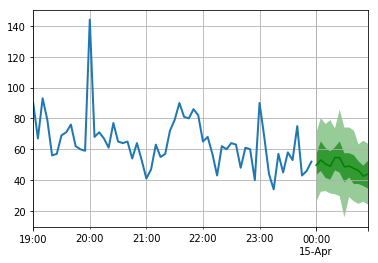

In [60]:
plot_forecast(predictor=deepar_predictor, test_data=test_data)

## Saving the model
both training and prediction netwoeks can be saved using `estimator.serialize_prediction_net` and `estimator.serialize` respectively.

In [38]:
deepar_predictor.serialize_prediction_net(pathlib.Path("../model/deepar"))
deepar_predictor.serialize(pathlib.Path("../model/deepar"))

## Evaluating the model
Below we are using `gluonts.evaluation.Evaluator` to create an aggregated evaluation metrics of the model we have trained. The `Evaluator` accepts predictions and calculates multiple evaluation metrics such as "MSE" and "Quantile Loss". The `Evaluator` returns both a dictionary and a pandas DataFrame. You can use the python dictionary, first output, or the pandas DataFrame, the second output, depending on what you would like to do. The dictionary item includes more values.

In [87]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
forecast_it, ts_it = make_evaluation_predictions(dataset=test_data, 
                                                        predictor=deepar_predictor, 
                                                        num_eval_samples=100)
deepar_agg_metrics, item_metrics = Evaluator()(ts_it, 
                                                forecast_it, 
                                                 num_series=len(training_data))
deepar_agg_metrics

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


{'MSE': 277.30218505859375,
 'abs_error': 144.6739501953125,
 'abs_target_sum': 665.0,
 'abs_target_mean': 55.416666666666664,
 'seasonal_error': 12.780532802007231,
 'MASE': 0.9433223718484236,
 'sMAPE': 0.21437652144621286,
 'MSIS': 15.394992391082795,
 'QuantileLoss[0.0]': 0.0,
 'Coverage[0.0]': 0.0,
 'QuantileLoss[0.1]': 53.00911598205567,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.2]': 87.10491333007813,
 'Coverage[0.2]': 0.08333333333333333,
 'QuantileLoss[0.3]': 115.23881759643555,
 'Coverage[0.3]': 0.25,
 'QuantileLoss[0.4]': 133.69203033447266,
 'Coverage[0.4]': 0.3333333333333333,
 'QuantileLoss[0.5]': 144.6739616394043,
 'Coverage[0.5]': 0.4166666666666667,
 'QuantileLoss[0.6]': 153.61671600341796,
 'Coverage[0.6]': 0.5,
 'QuantileLoss[0.7]': 151.86901473999026,
 'Coverage[0.7]': 0.5833333333333334,
 'QuantileLoss[0.8]': 137.81213989257813,
 'Coverage[0.8]': 0.75,
 'QuantileLoss[0.9]': 105.66009674072265,
 'Coverage[0.9]': 0.75,
 'RMSE': 16.652392772769737,
 'NRMSE': 0.30049430

In [95]:
item_metrics.T

,0
Coverage[0.0],0.000000
Coverage[0.1],0.000000
Coverage[0.2],0.083333
Coverage[0.3],0.250000
Coverage[0.4],0.333333
Coverage[0.5],0.416667
Coverage[0.6],0.500000
Coverage[0.7],0.583333
Coverage[0.8],0.750000
Coverage[0.9],0.750000


## Comparing models.
We now use another estimator, `SimpleFeedForwardEstimator`, to make the same forecast. This model is using a simple MLP or a feed forward network to reach the same goal. At the end we shall compare the results of the models.

In [89]:
mlp_estimator = SimpleFeedForwardEstimator(freq="5min", 
                                           prediction_length=12, 
                                           trainer=Trainer(epochs=EPOCHS))
mlp_predictor = mlp_estimator.train(training_data=training_data)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 523
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 103.89it/s, avg_epoch_loss=4.5]
INFO:root:Epoch[0] Elapsed time 0.483 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.500883
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 113.96it/s, avg_epoch_loss=4.27]
INFO:root:Epoch[1] Elapsed time 0.441 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.271691
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 109.67it/s, avg_epoch_loss=4.25]
INFO:root:Epoch[2] Elapsed time 0.459 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.250399
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 112.78it/s, avg_epoch_loss=4.21]
INFO:root:Epoch[3] Elapsed time 0.445 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.211581
INFO:root:Epoch[4] Learning ra

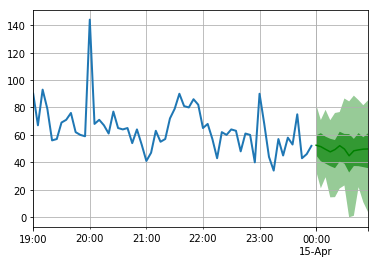

In [90]:
plot_forecast(predictor=mlp_predictor, test_data=test_data)

In [48]:
mlp_predictor.serialize_prediction_net(pathlib.Path("../model/mlp"))
mlp_predictor.serialize(pathlib.Path("../model/mlp"))

## Comparing the results
The code snippet below, is using the same mechanism we have used before for evaluation, exceot the function accepts data and a list of predictors as well as a textual name for the predictors to use as column name in the pandas DataFrame output. It then loops over predictors, performs evaluation, converts the evaluation dictoinary into a pandas DataFrame, and appends the output of evaluation to a dataframe as as a new column.

In [102]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
def evaluat_models_from_dict(data, predictors, predictor_names, num_samples=100):
    '''
    Comparing results of multiple models.
    Parameters:
        data: the dataset on which we are performing the evaluation.
        predictors: A list of predictor objects
        predictor_names: A list of textual names for the predictors that have an ordered one-to-one
                         relationship with the predictors.
        num_samples (default=100): what sample size from the evaluation dataset.
    Output: pandas dataframe to an evaluation column per predictor.
    '''
    df = pd.DataFrame()
    for (predictor, predictor_name) in zip(predictors, predictor_names):
        forecast_it, ts_it = make_evaluation_predictions(data, 
                                                        predictor=predictor, 
                                                        num_eval_samples=num_samples)
        deepar_agg_metrics, item_metrics = Evaluator()(ts_it, 
                                                       forecast_it, 
                                                       num_series=len(data))

        evaluation = pd.DataFrame.from_dict(deepar_agg_metrics, orient='index', columns=[predictor_name])
        if df.empty:
            df = evaluation.copy()
        else:
            df.insert(loc=len(df.columns), column=predictor_name, value=evaluation.values)
    return df
evaluat_models_from_dict(data=test_data, 
               predictors=[deepar_predictor, mlp_predictor], 
               predictor_names = ['deepar', 'mlp'])

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s]


,deepar,mlp
MSE,239.602905,253.508016
abs_error,135.064880,140.744186
abs_target_sum,665.000000,665.000000
abs_target_mean,55.416667,55.416667
seasonal_error,12.780533,12.780533
MASE,0.880668,0.917699
sMAPE,0.199132,0.208549
MSIS,13.750851,16.149610
QuantileLoss[0.0],0.000000,0.000000
Coverage[0.0],0.000000,0.000000


## Accessing weights and model parameters
You can use an estimator and call `train_model` in order to get access to the netword structure and parameters. `train_model` is an instance of `DeepARTrainingNetwork`, which in turn is derived from `DeepARNetwork`, which itself is derived from `mxnet.gluon.block.HybridBlock`.
The following code demonstrates how to lookup the objects lineage.

In [116]:
gluonts.model.deepar._network.DeepARTrainingNetwork.__bases__[0].__bases__[0]

mxnet.gluon.block.HybridBlock

In [117]:
train_transformation, train_model = deepar_estimator.train_model(training_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.71it/s, avg_epoch_loss=4.26]
INFO:root:Epoch[0] Elapsed time 4.272 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.256876
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.63it/s, avg_epoch_loss=4.06]
INFO:root:Epoch[1] Elapsed time 4.301 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.058940
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.70it/s, avg_epoch_loss=4.02]
INFO:root:Epoch[2] Elapsed time 4.275 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.020122
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.25it/s, avg_epoch_loss=4]
INFO:root:Epoch[3] Elapsed time 4.084 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.996138
INFO:root:Epoch[4] Learning rate is 0.001
100

We can now call `DeepARTrainingNetwork.collect_params()`, which returns a `mxnet.gluon.parameter.ParameterDict` object. for more information how to query `ParameterDict`, plese refer to [mxnet documentation.](https://mxnet.incubator.apache.org/api/python/gluon/gluon.html#mxnet.gluon.ParameterDict)

In [138]:
train_model.collect_params()

deepartrainingnetwork8_ (
  Parameter deepartrainingnetwork8_None_distr_mu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_None_distr_mu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_None_distr_sigma_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_None_distr_sigma_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_None_distr_nu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_None_distr_nu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_lstm0_i2h_weight (shape=(160, 61), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_lstm0_h2h_weight (shape=(160, 40), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_lstm0_i2h_bias (shape=(160,), dtype=<class 'numpy.float32'>)
  Parameter deepartrainingnetwork8_lstm0_h2h_bias (shape=(160,), dt